File /Users/wanglei/.tvm_test_data/darknet/yolov3.cfg exists, skip.
File /Users/wanglei/.tvm_test_data/darknet/yolov3.weights exists, skip.
File /Users/wanglei/.tvm_test_data/data/coco.names exists, skip.
File /Users/wanglei/.tvm_test_data/data/arial.ttf exists, skip.
File /Users/wanglei/.tvm_test_data/darknet/dog.jpg exists, skip.
File /Users/wanglei/.tvm_test_data/darknet/libdarknet_mac2.0.so exists, skip.
Compiling the model...


Cannot find config for target=llvm -keys=cpu, workload=('conv2d_NCHWc.x86', ('TENSOR', (1, 3, 416, 416), 'float32'), ('TENSOR', (32, 3, 3, 3), 'float32'), (1, 1), (1, 1, 1, 1), (1, 1), 'NCHW', 'NCHW', 'float32'). A fallback configuration is used, which may bring great performance regression.
Cannot find config for target=llvm -keys=cpu, workload=('conv2d_NCHWc.x86', ('TENSOR', (1, 32, 416, 416), 'float32'), ('TENSOR', (64, 32, 3, 3), 'float32'), (2, 2), (1, 1, 1, 1), (1, 1), 'NCHW', 'NCHW', 'float32'). A fallback configuration is used, which may bring great performance regression.
Cannot find config for target=llvm -keys=cpu, workload=('conv2d_NCHWc.x86', ('TENSOR', (1, 64, 208, 208), 'float32'), ('TENSOR', (32, 64, 1, 1), 'float32'), (1, 1), (0, 0, 0, 0), (1, 1), 'NCHW', 'NCHW', 'float32'). A fallback configuration is used, which may bring great performance regression.
Cannot find config for target=llvm -keys=cpu, workload=('conv2d_NCHWc.x86', ('TENSOR', (1, 32, 208, 208), 'float32'),

Cannot find config for target=llvm -keys=cpu, workload=('conv2d_NCHWc.x86', ('TENSOR', (1, 64, 26, 26, 8), 'float32'), ('TENSOR', (32, 64, 1, 1, 8, 8), 'float32'), (1, 1), (0, 0, 0, 0), (1, 1), 'NCHW8c', 'NCHW8c', 'float32'). A fallback configuration is used, which may bring great performance regression.
Cannot find config for target=llvm -keys=cpu, workload=('conv2d_NCHWc.x86', ('TENSOR', (1, 32, 26, 26, 8), 'float32'), ('TENSOR', (64, 32, 3, 3, 8, 8), 'float32'), (1, 1), (1, 1, 1, 1), (1, 1), 'NCHW8c', 'NCHW8c', 'float32'). A fallback configuration is used, which may bring great performance regression.
Cannot find config for target=llvm -keys=cpu, workload=('conv2d_NCHWc.x86', ('TENSOR', (1, 96, 26, 26, 8), 'float32'), ('TENSOR', (32, 96, 1, 1, 8, 8), 'float32'), (1, 1), (0, 0, 0, 0), (1, 1), 'NCHW8c', 'NCHW8c', 'float32'). A fallback configuration is used, which may bring great performance regression.
Cannot find config for target=llvm -keys=cpu, workload=('conv2d_NCHWc.x86', ('TENS

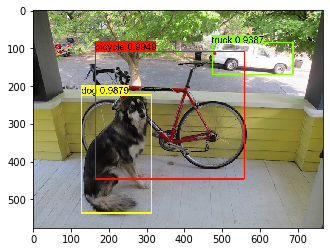

In [1]:
# numpy matplot and sys 
import numpy as np
import matplotlib.pyplot as plt
import sys

# Load tvm ref
import tvm
from tvm import relay
from tvm.contrib.download import download_testdata
from tvm.relay.testing.darknet import __darknetffi__
from tvm.contrib import graph_runtime
import tvm.relay.testing.yolo_detection
import tvm.relay.testing.darknet
## Download Pretrained YoloV3 model params
MODEL_NAME = "yolov3"
CFG_NAME = MODEL_NAME + ".cfg"
WEIGHTS_NAME = MODEL_NAME + ".weights"
REPO_URL = "https://github.com/dmlc/web-data/blob/master/darknet/"
CFG_URL = REPO_URL + "cfg/" + CFG_NAME + "?raw=true"
WEIGHTS_URL = "https://pjreddie.com/media/files/" + WEIGHTS_NAME

cfg_path = download_testdata(CFG_URL, CFG_NAME, module="darknet")
weights_path = download_testdata(WEIGHTS_URL, WEIGHTS_NAME, module="darknet")

COCO_NAME = "coco.names"
COCO_URL = REPO_URL + "data/" + COCO_NAME + "?raw=true"
FONT_NAME = "arial.ttf"
FONT_URL = REPO_URL + "data/" + FONT_NAME + "?raw=true"
coco_path = download_testdata(COCO_URL, COCO_NAME, module="data")
font_path = download_testdata(FONT_URL, FONT_NAME, module="data")

## Download test image
IMAGE_NAME = "dog.jpg"
IMAGE_URL = REPO_URL + "data/" + IMAGE_NAME + "?raw=true"
img_path = download_testdata(IMAGE_URL, IMAGE_NAME, module="darknet")
## Download and Load darknet library
if sys.platform in ["linux", "linux2"]:
    DARKNET_LIB = "libdarknet2.0.so"
    DARKNET_URL = REPO_URL + "lib/" + DARKNET_LIB + "?raw=true"
elif sys.platform == "darwin":
    DARKNET_LIB = "libdarknet_mac2.0.so"
    DARKNET_URL = REPO_URL + "lib_osx/" + DARKNET_LIB + "?raw=true"
else:
    err = "Darknet lib is not supported on {} platform".format(sys.platform)
    raise NotImplementedError(err)

lib_path = download_testdata(DARKNET_URL, DARKNET_LIB, module="darknet")
darknet_lib = __darknetffi__.dlopen(lib_path)
net = darknet_lib.load_network(cfg_path.encode("utf-8"), weights_path.encode("utf-8"), 0)

# Get moduleIR and params
dtype = "float32"
batch_size = 1
data = np.empty([batch_size, net.c, net.h, net.w], dtype=dtype)
shape = {"data": data.shape}
mod, params = relay.frontend.from_darknet(net, shape=data.shape, dtype=dtype)

# compile the module
target = "llvm"
target_host = "llvm"
ctx = tvm.cpu(0)
data = np.empty([batch_size, net.c, net.h, net.w], dtype)
shape = {"data": data.shape}
print("Compiling the model...")
with tvm.transform.PassContext(opt_level=3):
    lib = relay.build(mod, target=target, target_host=target_host, params=params)

[neth, netw] = shape["data"][2:]  # Current image shape is 608x608
data = relay.testing.darknet.load_image(img_path, netw, neth)

## Execution on TVM Runtime
module = graph_runtime.GraphModule(lib["default"](ctx))
module.set_input("data", tvm.nd.array(data.astype(dtype)))

thresh, nms_thresh = 0.5, 0.45
module.run()
tvm_out = []
if MODEL_NAME == "yolov2":
    layer_out = {}
    layer_out["type"] = "Region"
    # Get the region layer attributes (n, out_c, out_h, out_w, classes, coords, background)
    layer_attr = module.get_output(2).asnumpy()
    layer_out["biases"] = module.get_output(1).asnumpy()
    out_shape = (layer_attr[0], layer_attr[1] // layer_attr[0], layer_attr[2], layer_attr[3])
    layer_out["output"] = module.get_output(0).asnumpy().reshape(out_shape)
    layer_out["classes"] = layer_attr[4]
    layer_out["coords"] = layer_attr[5]
    layer_out["background"] = layer_attr[6]
    tvm_out.append(layer_out)

elif MODEL_NAME == "yolov3":
    for i in range(3):
        layer_out = {}
        layer_out["type"] = "Yolo"
        # Get the yolo layer attributes (n, out_c, out_h, out_w, classes, total)
        layer_attr = module.get_output(i * 4 + 3).asnumpy()
        layer_out["biases"] = module.get_output(i * 4 + 2).asnumpy()
        layer_out["mask"] = module.get_output(i * 4 + 1).asnumpy()
        out_shape = (layer_attr[0], layer_attr[1] // layer_attr[0], layer_attr[2], layer_attr[3])
        layer_out["output"] = module.get_output(i * 4).asnumpy().reshape(out_shape)
        layer_out["classes"] = layer_attr[4]
        tvm_out.append(layer_out)

elif MODEL_NAME == "yolov3-tiny":
    for i in range(2):
        layer_out = {}
        layer_out["type"] = "Yolo"
        # Get the yolo layer attributes (n, out_c, out_h, out_w, classes, total)
        layer_attr = module.get_output(i * 4 + 3).asnumpy()
        layer_out["biases"] = module.get_output(i * 4 + 2).asnumpy()
        layer_out["mask"] = module.get_output(i * 4 + 1).asnumpy()
        out_shape = (layer_attr[0], layer_attr[1] // layer_attr[0], layer_attr[2], layer_attr[3])
        layer_out["output"] = module.get_output(i * 4).asnumpy().reshape(out_shape)
        layer_out["classes"] = layer_attr[4]
        tvm_out.append(layer_out)
        thresh = 0.560

# do the detection and bring up the bounding boxes
img = tvm.relay.testing.darknet.load_image_color(img_path)
_, im_h, im_w = img.shape
dets = tvm.relay.testing.yolo_detection.fill_network_boxes(
    (netw, neth), (im_w, im_h), thresh, 1, tvm_out
)
last_layer = net.layers[net.n - 1]
tvm.relay.testing.yolo_detection.do_nms_sort(dets, last_layer.classes, nms_thresh)


with open(coco_path) as f:
    content = f.readlines()

names = [x.strip() for x in content]

# relay.testing.yolo_detection.show_detections(img, dets, thresh, names, last_layer.classes)
relay.testing.yolo_detection.draw_detections(
    font_path, img, dets, thresh, names, last_layer.classes
)
plt.imshow(img.transpose(1, 2, 0))
plt.show()

In [5]:
lib["default"](ctx)

Module(GraphRuntime, 7fe5b287f1f8)